Configuration

In [1]:
TEST_RUN = True

GROUP_PATH = '/data/CrowdSkin/ekcontar/group/'
GROUND_TRUTH_PATH = '/data/CrowdSkin/ekcontar/'
IMAGE_DATA_PATH = '/data/CrowdSkin/ekcontar/dat/'
PROJECT_PATH = '/home/ralf/Projects/crowd-multitask/'

if TEST_RUN == True:
    EPOCHS_TRAIN_MODEL = 1
    STEPS_PER_EPOCH = 2
else:
    EPOCHS_TRAIN_MODEL = 200
    
    
BATCH_SIZE = 10

In [2]:
import sys
sys.path.append('../../')
import config as cf

import tensorflow as tf
import keras.backend.tensorflow_backend
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.65)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(session)

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import model_from_json
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

import random

/home/ralf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Label-Asymmetry Score
df_1 = pd.read_excel(GROUP_PATH + 'group01.xlsx')
df_2 = pd.read_excel(GROUP_PATH + 'group02.xlsx')
df_3 = pd.read_excel(GROUP_PATH + 'group03.xlsx')
df_4 = pd.read_excel(GROUP_PATH + 'group04.xlsx')
df_5 = pd.read_excel(GROUP_PATH + 'group05.xlsx')
df_6 = pd.read_excel(GROUP_PATH + 'group06.xlsx')
df_7 = pd.read_excel(GROUP_PATH + 'group07.xlsx')
df_3 = df_3.reset_index()
df_7 = df_7.dropna()
df_7 = df_7.reset_index()

In [4]:
# Reading each excel file containing crowd sourced attributes
a_1 = (preprocessing.scale(df_1['Asymmetry_1_1']) + preprocessing.scale(df_1['Asymmetry_1_2']) + preprocessing.scale(
    df_1['Asymmetry_1_3'])) / 3.0
a_2 = (preprocessing.scale(df_2['Asymmetrie']) + preprocessing.scale(df_2['Unnamed: 3']) + preprocessing.scale(
    df_2['Unnamed: 4'])) / 3.0
a_3 = (preprocessing.scale(df_3['Asymmetry_3_1']) + preprocessing.scale(df_3['Asymmetry_3_2']) + preprocessing.scale(
    df_3['Asymmetry_3_3'])) / 3.0
a_4 = (preprocessing.scale(df_4['Asymmetry_4_1']) + preprocessing.scale(df_4['Asymmetry_4_3']) + preprocessing.scale(
    df_4['Asymmetry_4_5'])) / 3.0
a_5 = (preprocessing.scale(df_5['Asymmetry_5_1']) + preprocessing.scale(df_5['Asymmetry_5_2']) + preprocessing.scale(
    df_5['Asymmetry_5_3'])) / 3.0
a_6 = (preprocessing.scale(df_6['Asymmetry_6_1']) + preprocessing.scale(df_6['Asymmetry_6_2']) + preprocessing.scale(
    df_6['Asymmetry_6_3'])) / 3.0
a_7 = (preprocessing.scale(df_7['Asymmetry_7_1']) + preprocessing.scale(
    df_7['Asymmetry_7_2']) + preprocessing.scale(df_7['Asymmetry_7_3']) + preprocessing.scale(
    df_7['Asymmetry_7_4']) + preprocessing.scale(df_7['Asymmetry_7_5']) + preprocessing.scale(
    df_7['Asymmetry_7_6'])) / 6.0

/home/ralf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [5]:

# Image filename list and label for asymmetry
asymm_label = np.concatenate((a_1, a_2, a_3, a_4, a_5, a_6, a_7))
asymm_id = np.concatenate(
    (df_1['ID'], df_2['Afbeelding'], df_3['index'], df_4['ID'], df_5['ID'], df_6['ID'], df_7['ID']))
# Image filename list and label for asymmetry
asymm_label = np.concatenate((a_1, a_2, a_3, a_4, a_5, a_6, a_7))
asymm_id = np.concatenate(
    (df_1['ID'], df_2['Afbeelding'], df_3['index'], df_4['ID'], df_5['ID'], df_6['ID'], df_7['ID']))

# Image filename list and label for class
df = pd.read_csv(GROUND_TRUTH_PATH + 'ISIC-2017_Training_Part3_GroundTruth.csv')
class_label = df['melanoma']
class_id = df['image_id']

a_label = []
mask = []
for i in range(len(class_id)):
    for j in range(len(asymm_id)):
        if (class_id[i] == asymm_id[j]):
            a_label.append(asymm_label[j])
            mask.append(1.)
            break
        elif (j == 689):  # length of asymmetry_id array
            a_label.append(0.)
            mask.append(0.)

In [6]:
class_id_ = []
class_label_ = []
a_label_ = []
mask_ = []

# Shuffle dataset
indexes = list(range(len(class_id)))
random.Random(4).shuffle(
    indexes)  # To produce same train and valid set every time. DO NOT use seed=4, because it will pollute randomness of the rest of the program.
for index in indexes:
    class_id_.append(class_id[index])
    class_label_.append(class_label[index])
    a_label_.append(a_label[index])
    mask_.append(mask[index])

train_id = class_id_[:-600]  # 1400 training
train_label_c = class_label_[:-600]
train_label_a = a_label_[:-600]
train_mask = mask_[:-600]

valid_id = class_id_[1400:1750]  # 350 valid
valid_label_c = class_label_[1400:1750]
valid_label_a = a_label_[1400:1750]
valid_mask = mask_[:-600]

test_id = class_id_[1750:]  # 250 test
test_label_c = class_label_[1750:]
test_label_a = a_label_[1750:]
test_mask = mask_[:-600]

In [7]:
# Data Generator
def generate_data(directory, augmentation, shuffle, batch_size, file_list, label_1, label_2, mask):
    i = 0
    shuff_file_list = file_list
    shuff_label_1 = label_1
    shuff_label_2 = label_2
    shuff_mask = mask

    while True:
        image_batch = []
        label_1_batch = []
        label_2_batch = []
        sample_weight = []
        for b in range(batch_size):
            if i == (len(file_list)):
                i = 0
                if shuffle == True:
                    new_file_list = []
                    new_label_1 = []
                    new_label_2 = []
                    new_mask = []
                    indexes = list(range(len(shuff_file_list)))
                    random.shuffle(indexes)
                    for index in indexes:
                        new_file_list.append(shuff_file_list[index])
                        new_label_1.append(shuff_label_1[index])
                        new_label_2.append(shuff_label_2[index])
                        new_mask.append(shuff_mask[index])
                    shuff_file_list = new_file_list
                    shuff_label_1 = new_label_1
                    shuff_label_2 = new_label_2
                    shuff_mask = new_mask

            img = image.load_img(directory + shuff_file_list[i] + '.jpg', grayscale=False, target_size=(384, 384))
            img = image.img_to_array(img)
            if augmentation == True:
                datagen = ImageDataGenerator(
                    rotation_range=360,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode="nearest")
                img = datagen.random_transform(img)
                img = img / 255.0

            if augmentation == False:
                img = img / 255.0
            image_batch.append(img)
            label_1_batch.append(shuff_label_1[i])
            label_2_batch.append(shuff_label_2[i])
            sample_weight.append(shuff_mask[i])
            i = i + 1

        if (all(sample == 0 for sample in sample_weight)):
            yield (np.asarray(image_batch_r),
                   ({'out_class': np.asarray(label_1_batch_r), 'out_asymm': np.asarray(label_2_batch_r)}),
                   ({'out_asymm': np.asarray(sample_weight_r)}))
        else:
            image_batch_r = image_batch  # Memory, when all the samples for asymmetry score is zero generator returns previous batch instead of zeros
            label_1_batch_r = label_1_batch
            label_2_batch_r = label_2_batch
            sample_weight_r = sample_weight
            yield (
            np.asarray(image_batch), ({'out_class': np.asarray(label_1_batch), 'out_asymm': np.asarray(label_2_batch)}),
            ({'out_asymm': np.asarray(sample_weight)}))


In [8]:
#Read data
train=generate_data(IMAGE_DATA_PATH, augmentation=True, shuffle=True, batch_size=BATCH_SIZE, file_list=train_id, label_1=train_label_c, label_2=train_label_a, mask=train_mask)
validation=generate_data(IMAGE_DATA_PATH, augmentation=False, shuffle=True, batch_size=BATCH_SIZE, file_list=valid_id, label_1=valid_label_c, label_2=valid_label_a, mask=valid_mask)

In [9]:
#Build the model
img_height, img_width, img_channel=384,384,3
input_tensor = Input(shape=(img_height, img_width, img_channel))
vgg_new_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(img_height, img_width, img_channel), pooling='avg')
for layer in vgg_new_model.layers[:-5]:
    layer.trainable = True
l2=Dense(100, activation='relu')(vgg_new_model.output)
l3=Dense(100, activation='relu')(l2)
out_class=Dense(1, activation='sigmoid', name='out_class')(l3)
out_asymm=Dense(1, activation='linear', name='out_asymm')(l3)
model= Model(inputs=vgg_new_model.input, outputs=[out_class, out_asymm])

#Check the model
model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 384, 384, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 384, 384, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 384, 384, 64)  36928                                        
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 192, 192, 64)  0                                            
__________________

In [10]:
tfdir = PROJECT_PATH + 'logs/multitask/'
tensorboard = TensorBoard(log_dir=tfdir, write_graph=True)
callbacks = [tensorboard]

#Compile model
opt=keras.optimizers.SGD(lr=0.001, momentum=0.90)
model.compile(loss={'out_class': 'binary_crossentropy', 'out_asymm':'mse'}, optimizer=opt, metrics={'out_class': 'accuracy'}, loss_weights={'out_class': 0.5, 'out_asymm': 0.5})


if TEST_RUN == False:
    STEPS_PER_EPOCH = (len(train_id)//BATCH_SIZE)

#Fit model
history=model.fit_generator(train, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_TRAIN_MODEL,  class_weight={'out_class':{0:1.,1:5.}}, validation_data=validation, validation_steps=(len(valid_id)//BATCH_SIZE)) 

Epoch 1/1
2/2 [==============================] - 166s - loss: 0.9460 - out_class_loss: 1.4481 - out_asymm_loss: 0.4438 - out_class_acc: 0.8000 - val_loss: 0.4114 - val_out_class_loss: 0.5402 - val_out_asymm_loss: 0.2825 - val_out_class_acc: 0.8086


In [11]:
#save model to JSON
model_json = model.to_json()
with open(PROJECT_PATH + "weights/mu.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(PROJECT_PATH + "weights/mu.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
def mse(y_true, y_pred):
	mask=[]
	for i in range(0,10):
		if y_true[i]==0	:
			mask.append(0.0)
		else: 
			mask.append(1.0)
	if all(value == 0 for value in mask):
		
		return 0.
	else:
		mask=np.array(mask)
		mask = K.cast(mask, K.floatx())
		score_array = K.square(y_true- y_pred)
		score_array *= mask
		score_array /= K.mean(K.cast(K.not_equal(mask, 0), K.floatx()))
		return K.mean(score_array)

In [13]:
#Load model
json_file = open(PROJECT_PATH + 'weights/mu.json', 'r')
model_json = json_file.read()
json_file.close()
load_model = model_from_json(model_json)

#Load weights into new model
load_model.load_weights(PROJECT_PATH + "weights/mu.h5")
test=generate_data(IMAGE_DATA_PATH, augmentation=False, shuffle=False, batch_size=10, file_list=test_id, label_1=test_label_c, label_2=test_label_a, mask=test_mask)

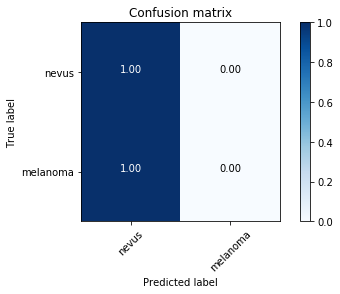

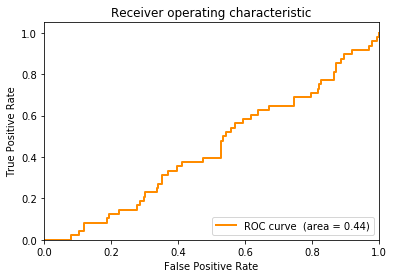

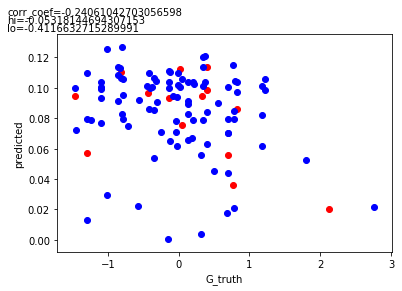

In [14]:
#Make prediction
y_pred = load_model.predict_generator(test, steps=25)
y_pred_c=(y_pred[0])
y_true_c=test_label_c
y_pred_c=np.array(y_pred_c)


#Confusion matrix
classes={'nevus': 0, 'melanoma': 1}
thre=0.5
# obtain class predictions from probabilities
y_predi=(y_pred_c>=thre)*1
# obtain (unnormalized) confusion matrix
cm = confusion_matrix(y_true_c, y_predi)
# normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
	plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(PROJECT_PATH + 'reports/Multitask_Confusion_Matrix.png')
plt.show()

#ROC curve and score
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true_c, y_pred_c)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
label='ROC curve  (area = {f:.2f})'.format( f=roc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.savefig(PROJECT_PATH + 'Multitask_ROC.png')
plt.show()

#Calcuate correlation coefficient
y_pred_a=y_pred[1].reshape((250,))
y_true_a=np.array(test_label_a)

#Remove all zeros from missing labels
for index in range(0,250):
	if y_true_a[index]==0:
		y_pred_a[index]=0

y_pred_a = y_pred_a[y_pred_a != 0]
y_true_a = y_true_a[y_true_a != 0]

r, p = stats.pearsonr(y_true_a, y_pred_a)
alpha=0.05
r_z = np.arctanh(r)
se = 1/np.sqrt(y_true_a.size-3)
z = stats.norm.ppf(1-alpha/2)
lo_z, hi_z = r_z-z*se, r_z+z*se
lo, hi = np.tanh((lo_z, hi_z))
corr_coef=np.corrcoef(y_pred_a, y_true_a)

#Plot correlation scatter plot
y_p_1=[]
y_t_1=[]
y_p_2=[]
y_t_2=[]
for i in range(len(y_true_a)):
	if test_label_c[i]==1:
		y_p_1.append(y_pred_a[i])
		y_t_1.append(y_true_a[i])
	else:
		y_p_2.append(y_pred_a[i])
		y_t_2.append(y_true_a[i])
y_p_1=np.array(y_p_1)
y_t_1=np.array(y_t_1)
y_p_2=np.array(y_p_2)
y_t_2=np.array(y_t_2)
plt.scatter(y_t_1, y_p_1, color='r')	#red points for melanoma
plt.scatter(y_t_2, y_p_2, color='b')	#blue points for non-melanoma
plt.xlabel("G_truth")
plt.ylabel("predicted")
plt.figtext(0.01, 0.95, 'corr_coef='+str(r), fontsize=10)
plt.figtext(0.01, 0.92, 'hi='+str(hi), fontsize=10)
plt.figtext(0.01, 0.89, 'lo='+str(lo), fontsize=10)
plt.show()
plt.savefig(PROJECT_PATH + 'Correlation_Scatter_Plot.png')